<a href="https://colab.research.google.com/github/mananuppadhyay/IPARC-Decision-trees/blob/main/Method_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ac20/IPARC_ChallengeV2/

fatal: destination path 'IPARC_ChallengeV2' already exists and is not an empty directory.


In [ ]:
%cd /content/IPARC_ChallengeV2

/content/IPARC_ChallengeV2


Print one input output pair



In [ ]:

import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from xgboost import XGBClassifier
import pdb

Create a dataframe with difference of input and output pixel values

In [ ]:
def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):

    if cur_row<=0: top = -1
    else: top = color[cur_row-1][cur_col]

    if cur_row>=nrows-1: bottom = -1
    else: bottom = color[cur_row+1][cur_col]

    if cur_col<=0: left = -1
    else: left = color[cur_row][cur_col-1]

    if cur_col>=ncols-1: right = -1
    else: right = color[cur_row][cur_col+1]

    return top, bottom, left, right



Import the structural elements, code from the github repo



In [ ]:
import numpy as np
from skimage.morphology import disk

# Square
SE1_3x3 = np.ones((3, 3), dtype=np.int32)
SE1_5x5 = np.ones((5, 5), dtype=np.int32)

# Disk
SE2_3x3 = np.array(disk(1), dtype=np.int32)
SE2_5x5 = np.array(disk(2), dtype=np.int32)

# Cross
SE3_3x3 = np.zeros((3, 3), dtype=np.int32)
SE3_3x3[(0, 1, 2), (0, 1, 2)] = 1
SE3_3x3[(0, 1, 2), (2, 1, 0)] = 1
SE3_5x5 = np.zeros((5, 5), dtype=np.int32)
SE3_5x5[(0, 1, 2, 3, 4), (0, 1, 2, 3, 4)] = 1
SE3_5x5[(0, 1, 2, 3, 4), (4, 3, 2, 1, 0)] = 1

# Plus
SE4_3x3 = np.zeros((3, 3), dtype=np.int32)
SE4_3x3[1, :] = 1
SE4_3x3[:, 1] = 1
SE4_5x5 = np.zeros((5, 5), dtype=np.int32)
SE4_5x5[2, :] = 1
SE4_5x5[:, 2] = 1

# Rhombus
SE5_3x3 = np.array(disk(1), dtype=np.int32)
SE5_3x3[1, 1] = 0
SE5_5x5 = np.array(disk(2), dtype=np.int32)
SE5_5x5[(1, 2, 2, 2, 3), (2, 1, 2, 3, 3)] = 0

# Square (Empty)
SE7_3x3 = np.ones((3, 3), dtype=np.int32)
SE7_3x3[1, 1] = 0
SE7_5x5 = np.ones((5, 5), dtype=np.int32)
SE7_5x5[1:4, 1:4] = 0

# Line to right
SE8_3x3 = np.zeros((3, 3), dtype=np.int32)
SE8_3x3[:, 2] = 1
SE8_5x5 = np.zeros((5, 5), dtype=np.int32)
SE8_5x5[:, 4] = 1

# Line to left
SE9_3x3 = np.zeros((3, 3), dtype=np.int32)
SE9_3x3[:, 0] = 1
SE9_5x5 = np.zeros((5, 5), dtype=np.int32)
SE9_5x5[:, 0] = 1

# Line to Top
SE10_3x3 = np.zeros((3, 3), dtype=np.int32)
SE10_3x3[0, :] = 1
SE10_5x5 = np.zeros((5, 5), dtype=np.int32)
SE10_5x5[0, :] = 1

# Line to Bottom
SE11_3x3 = np.zeros((3, 3), dtype=np.int32)
SE11_3x3[-1, :] = 1
SE11_5x5 = np.zeros((5, 5), dtype=np.int32)
SE11_5x5[-1, :] = 1

list_se_3x3 = [SE3_3x3, SE4_3x3, SE5_3x3, SE7_3x3, SE8_3x3, SE9_3x3, SE10_3x3, SE11_3x3]
list_se_3x3_names = ['SE1', 'SE2', 'SE3', 'SE4', 'SE5', 'SE6', 'SE7', 'SE8']
list_se_5x5 = [SE3_5x5, SE4_5x5, SE5_5x5, SE7_5x5, SE8_5x5, SE9_5x5, SE10_5x5, SE11_5x5]

In [ ]:
SE3_3x3

array([[1, 0, 1],
       [0, 1, 0],
       [1, 0, 1]], dtype=int32)

In [ ]:
from scipy import ndimage

In [ ]:
%cd /content/IPARC_ChallengeV2/Dataset/CatA_Simple
# Create a new directory to store the output files
if not os.path.exists('output'):
    os.mkdir('output')
ses= list_se_3x3
se_names= list_se_3x3_names
# Load the input-output image pairs from JSON files and create a list of dictionaries
# where each dictionary represents a single output image with the input and output
# pixels as features and the erosion and structuring element used as additional features
data_list = []
for i in range(100):
    with open(f'Task{i:03d}.json', 'r') as f:
        data = json.load(f)
    input_image = np.array(data[0]['input'])
    output_image = np.array(data[0]['output'])

    for idx, se in enumerate(ses):
        se_name = se_names[idx]
        # Perform erosion and dilation using the structuring element on the input image
        eroded = ndimage.binary_erosion(input_image, structure=se).astype(np.int)
        dilated = ndimage.binary_dilation(input_image, structure=se).astype(np.int)
   # Save the eroded and dilated arrays as separate JSON files in the output directory
        eroded_filename = f'output/task{i:03d}_{se_name}_erosion.json'
        dilated_filename = f'output/task{i:03d}_{se_name}_dilation.json'
        with open(eroded_filename, 'w') as f:
            json.dump({'input': input_image.tolist(), 'output': eroded.tolist()}, f)
        with open(dilated_filename, 'w') as f:
            json.dump({'input': input_image.tolist(), 'output': dilated.tolist()}, f)

        # Create dictionaries with the input and output pixel values, erosion/dilation
        # type, and structuring element name, and append them to the data_list
        d_eroded = {'Input_Pixel_{}'.format(j): input_image.flatten()[j] for j in range(len(input_image.flatten()))}
        d_eroded.update({'Output_Pixel_{}'.format(j): eroded.flatten()[j] for j in range(len(eroded.flatten()))})
        d_eroded['Erosion/Dilation'] = 'Erosion'
        d_eroded['SE'] = se_name
        data_list.append(d_eroded)

        d_dilated = {'Input_Pixel_{}'.format(j): input_image.flatten()[j] for j in range(len(input_image.flatten()))}
        d_dilated.update({'Output_Pixel_{}'.format(j): dilated.flatten()[j] for j in range(len(dilated.flatten()))})
        d_dilated['Erosion/Dilation'] = 'Dilation'
        d_dilated['SE'] = se_name
        data_list.append(d_dilated)

# Create a dataframe from the list of dictionaries and save it to a CSV file
df = pd.DataFrame(data_list)

/content/IPARC_ChallengeV2/Dataset/CatA_Simple


<ipython-input-126-b3b7f7c9c4aa>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eroded = ndimage.binary_erosion(input_image, structure=se).astype(np.int)
<ipython-input-126-b3b7f7c9c4aa>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

In [ ]:
df.head()

,Input_Pixel_0,Input_Pixel_1,Input_Pixel_2,Input_Pixel_3,Input_Pixel_4,Input_Pixel_5,Input_Pixel_6,Input_Pixel_7,Input_Pixel_8,Input_Pixel_9,...,Output_Pixel_217,Output_Pixel_218,Output_Pixel_219,Output_Pixel_220,Output_Pixel_221,Output_Pixel_222,Output_Pixel_223,Output_Pixel_224,Erosion/Dilation,SE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Erosion,SE1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,Dilation,SE1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Erosion,SE2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,Dilation,SE2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Erosion,SE3


In [ ]:
%cd /content/

df.to_csv('file1.csv')

/content


In [ ]:
df1= df.drop(['Erosion/Dilation',	'SE'],axis=1)
df1.head()

,Input_Pixel_0,Input_Pixel_1,Input_Pixel_2,Input_Pixel_3,Input_Pixel_4,Input_Pixel_5,Input_Pixel_6,Input_Pixel_7,Input_Pixel_8,Input_Pixel_9,...,Output_Pixel_215,Output_Pixel_216,Output_Pixel_217,Output_Pixel_218,Output_Pixel_219,Output_Pixel_220,Output_Pixel_221,Output_Pixel_222,Output_Pixel_223,Output_Pixel_224
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating a new dataframe with the difference of input and output pixels

In [ ]:
new_col_names = ["Pixel_" + str(i) for i in range(1, 225)]

new_df = pd.DataFrame(columns=new_col_names)

for index, row in df.iterrows():
    abs_diff = [abs(row["Input_Pixel_" + str(i)] - row["Output_Pixel_" + str(i)]) for i in range(1, 225)]
    new_df.loc[index] = abs_diff

Looking at the effect of different operations on the same image

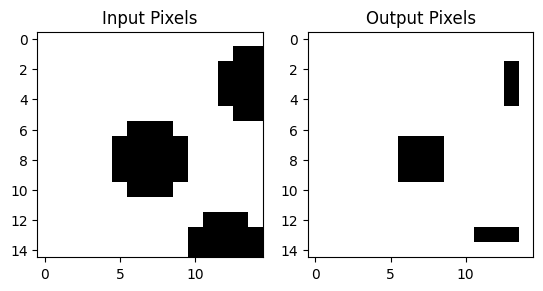

In [ ]:
input_p = df1.iloc[4, :225].values.reshape(15, 15)
output_p = df1.iloc[4, 225:].values.reshape(15, 15)
import matplotlib.pyplot as plt



fig, axs = plt.subplots(1, 2)
axs[0].imshow(input_p, cmap='binary')
axs[0].set_title('Input Pixels')
axs[1].imshow(output_p, cmap='binary')
axs[1].set_title('Output Pixels')
plt.show()

In [ ]:
df.shape

(1600, 452)

In [ ]:
new_df[['Erosion/Dilation','SE']]= df[['Erosion/Dilation','SE']]

In [ ]:
new_df.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_217,Pixel_218,Pixel_219,Pixel_220,Pixel_221,Pixel_222,Pixel_223,Pixel_224,Erosion/Dilation,SE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,Erosion,SE1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,Dilation,SE1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,Erosion,SE2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,Dilation,SE2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,Erosion,SE3


In [ ]:
X= df.copy().drop(['Erosion/Dilation','SE'], axis=1)

In [ ]:
y= df[['Erosion/Dilation','SE']].copy()

In [ ]:
y['fin']= y['Erosion/Dilation'] + ' ' + df['SE']
y= y.drop(['Erosion/Dilation','SE'],axis=1)
y.head()

,fin
0,Erosion SE1
1,Dilation SE1
2,Erosion SE2
3,Dilation SE2
4,Erosion SE3


In [ ]:
y_ohe = pd.get_dummies(y['fin'])

In [ ]:
y_ohe.head()

,Dilation SE1,Dilation SE2,Dilation SE3,Dilation SE4,Dilation SE5,Dilation SE6,Dilation SE7,Dilation SE8,Erosion SE1,Erosion SE2,Erosion SE3,Erosion SE4,Erosion SE5,Erosion SE6,Erosion SE7,Erosion SE8
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [ ]:
y_train.head()

,fin
1146,Erosion SE6
520,Erosion SE5
155,Dilation SE6
839,Dilation SE4
1335,Dilation SE4


In [ ]:
X_train.head()

,Input_Pixel_0,Input_Pixel_1,Input_Pixel_2,Input_Pixel_3,Input_Pixel_4,Input_Pixel_5,Input_Pixel_6,Input_Pixel_7,Input_Pixel_8,Input_Pixel_9,...,Output_Pixel_215,Output_Pixel_216,Output_Pixel_217,Output_Pixel_218,Output_Pixel_219,Output_Pixel_220,Output_Pixel_221,Output_Pixel_222,Output_Pixel_223,Output_Pixel_224
1146,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
839,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1335,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0


In [ ]:
models = {}
for column in y_train.columns:
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train[column])
    models[column] = model

# Evaluate the performance of the model on the test set
y_pred = pd.DataFrame()
for column, model in models.items():
    y_pred[column] = model.predict(X_test)


In [ ]:
y_pred.head(10)

,fin
0,Dilation SE2
1,Erosion SE1
2,Erosion SE1
3,Erosion SE4
4,Dilation SE4
5,Erosion SE1
6,Dilation SE2
7,Dilation SE1
8,Erosion SE8
9,Dilation SE7


In [ ]:
y_test.head(10)

,fin
213,Dilation SE3
998,Erosion SE4
1062,Erosion SE4
1486,Erosion SE8
1599,Dilation SE8
510,Erosion SE8
853,Dilation SE3
1143,Dilation SE4
558,Erosion SE8
954,Erosion SE6


In [ ]:
rows_match = y_pred.equals(y_test)
if rows_match:
    percent_match = 100
else:
    num_rows = len(y_pred)
    num_matches = sum([y_pred.iloc[i].equals(y_test.iloc[i]) for i in range(num_rows)])
    percent_match = num_matches / num_rows * 100

In [ ]:
print(percent_match)

11.5625
